<a href="https://colab.research.google.com/github/matjesg/deepflash2/blob/master/paper/benchmark_nnunet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# deepflash2 - nnunet benchmark

> This notebook reproduces the *nnunet* results of the deepflash2 [paper](https://arxiv.org/abs/2111.06693) for semantic and instance segmentation.

- **Data**: The data is available on [Google Drive](https://drive.google.com/drive/folders/1r9AqP9qW9JThbMIvT0jhoA5mPxWEeIjs?usp=sharing). To use the data in Google Colab, create a [shortcut](https://support.google.com/drive/answer/9700156?hl=en&co=GENIE.Platform%3DDesktop) of the data folder in your personal Google Drive.

- **Models**: The trained models are also available on [Google Drive](https://drive.google.com/drive/folders/1BZRrRTDuJw5EoBqz1RWoFKZ7eq2kEwxm?usp=sharing). To use the trained models for prediction, create a [shortcut](https://support.google.com/drive/answer/9700156?hl=en&co=GENIE.Platform%3DDesktop) of the data folder in your personal Google Drive.


*References*:

Griebel, M., Segebarth, D., Stein, N., Schukraft, N., Tovote, P., Blum, R., & Flath, C. M. (2021). Deep-learning in the bioimaging wild: Handling ambiguous data with deepflash2. arXiv preprint arXiv:2111.06693.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.


## Setup

- Install dependecies
- Connect to drive

In [ ]:
# Restart runtime after installation
!pip install nnunet

In [ ]:
# Imports
import os
import cv2
import imageio
import tifffile
import nibabel as nib
import numpy as np
from pathlib import Path
from skimage.color import label2rgb
import matplotlib.pyplot as plt

# According to the nnunet documentation: https://github.com/MIC-DKFZ/nnUNet/tree/master/documentation
os.environ['nnUNet_raw_data_base'] ="/content/nnUNet_raw"
os.environ['nnUNet_preprocessed']= "/content/nnUNet_preprocessed"
os.environ['RESULTS_FOLDER']= "/content/nnUNet_trained_models"
from nnunet.dataset_conversion.utils import generate_dataset_json
from nnunet.paths import nnUNet_raw_data, preprocessing_output_dir
from nnunet.utilities.file_conversions import convert_2d_image_to_nifti
from batchgenerators.utilities.file_and_folder_operations import *

In [ ]:
# Connect to drive
try:
  from google.colab import drive
  drive.mount('/gdrive')
except:
  print('Google Drive is not available.')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## Settings



Choose dataset from `PV_in_HC`,  `cFOS_in_HC`, `mScarlet_in_PAG`,  `YFP_in_CTX`,  `GFAP_in_HC`



In [ ]:
DATASET = 'cFOS_in_HC'
OUTPUT_DIR = "/content/predictions" # Save predictions here
DATA_PATH = Path('/gdrive/MyDrive/deepflash2-paper/data')
TRAINED_MODEL_FOLDER = '/gdrive/MyDrive/benchmark_models/nnunet/1'


task_dict = {
    'cFOS_in_HC': 100, 
    'YFP_in_CTX': 101, 
    'PV_in_HC' : 102,  
    'mScarlet_in_PAG': 103,  
    'GFAP_in_HC' : 104
}

## Data preprocessing

adapted from [nnunet github](https://github.com/MIC-DKFZ/nnUNet/blob/master/nnunet/dataset_conversion/Task120_Massachusetts_RoadSegm.py).

Dataset conversion

In [ ]:
# this folder should have the training and testing subfolders
base = DATA_PATH/DATASET

# now start the conversion to nnU-Net:
task_name = f"Task{task_dict[DATASET]}_{DATASET}"
target_base = Path(os.environ['nnUNet_raw_data_base'])/"nnUNet_raw_data"/task_name
target_imagesTr = target_base/"imagesTr"
target_imagesTs = target_base/"imagesTs"
target_labelsTs = target_base/"labelsTs"
target_labelsTr = target_base/"labelsTr"

maybe_mkdir_p(target_imagesTr)
maybe_mkdir_p(target_labelsTs)
maybe_mkdir_p(target_imagesTs)
maybe_mkdir_p(target_labelsTr)

# convert the training examples
images_dir_tr = base/'train'/'images'
labels_dir_tr = base/'train'/'masks_STAPLE'

training_cases = [x for x in images_dir_tr.iterdir()]
label_fn = lambda x: labels_dir_tr/f'{x.name[:-4]}_mask.png'

for t in training_cases:
    unique_name = t.name[:-4]
    input_segmentation_file = label_fn(t)

    output_image_file = target_imagesTr/unique_name  # do not specify a file ending! This will be done for you
    output_seg_file = target_labelsTr/unique_name  # do not specify a file ending! This will be done for you

    # this utility will convert 2d images that can be read by skimage.io.imread to nifti. You don't need to do anything.
    # if this throws an error for your images, please just look at the code for this function and adapt it to your needs
    convert_2d_image_to_nifti(t, output_image_file.as_posix(), is_seg=False)

    # the labels are stored as 0: background, 255: road. We need to convert the 255 to 1 because nnU-Net expects
    # the labels to be consecutive integers. This can be achieved with setting a transform
    convert_2d_image_to_nifti(input_segmentation_file, output_seg_file.as_posix(), is_seg=True,
                              transform=lambda x: (x == 255).astype(int))
    
# now do the same for the test set (no labels required)
images_dir_ts = base/'test'/'images'
testing_cases = [x for x in images_dir_ts.iterdir()]
for ts in testing_cases:
    unique_name = ts.name[:-4]
    output_image_file = target_imagesTs/unique_name
    convert_2d_image_to_nifti(ts, output_image_file.as_posix(), is_seg=False)

# finally we can call the utility for generating a dataset.json
generate_dataset_json(join(target_base, 'dataset.json'), target_imagesTr, target_imagesTs, ('noCT',),
                      labels={0: 'background', 1: 'fluorescent_label'}, dataset_name=task_name, license='hands off!')

nnunet preprocessing

In [ ]:
!nnUNet_plan_and_preprocess -t {task_dict[DATASET]} -pl3d None

## Train models

- This will take very long on Google Colab and not finish within the 12 hour limit for free GPU usage. 
- You can upgrade to Colab Pro or use the trained models from our paper (see next section).

In [ ]:
for FOLD in range(5):
  !nnUNet_train 2d nnUNetTrainerV2 {task_dict[DATASET]} {FOLD}

In [ ]:
# Run after training
!nnUNet_find_best_configuration -t {task_dict[DATASET]}  -m 2d

## Prediction on test set

We will use the trained models from our paper!



In [ ]:
os.environ['RESULTS_FOLDER']= TRAINED_MODEL_FOLDER

test_image_dir = f"{os.environ['nnUNet_raw_data_base']}/nnUNet_raw_data/{task_name}/imagesTs/"
prediction_dir = f"{OUTPUT_DIR}/{task_name}"
cmd = f"-i {test_image_dir} -o {prediction_dir} -t {task_name}"

!nnUNet_predict -tr nnUNetTrainerV2 -ctr nnUNetTrainerV2CascadeFullRes -m 2d -p nnUNetPlansv2.1 {cmd}

Convert to

- Semantic segmentation masks (.png)
- Instance segmentation masks (.tif) using the connected components algorithm

1599.nii


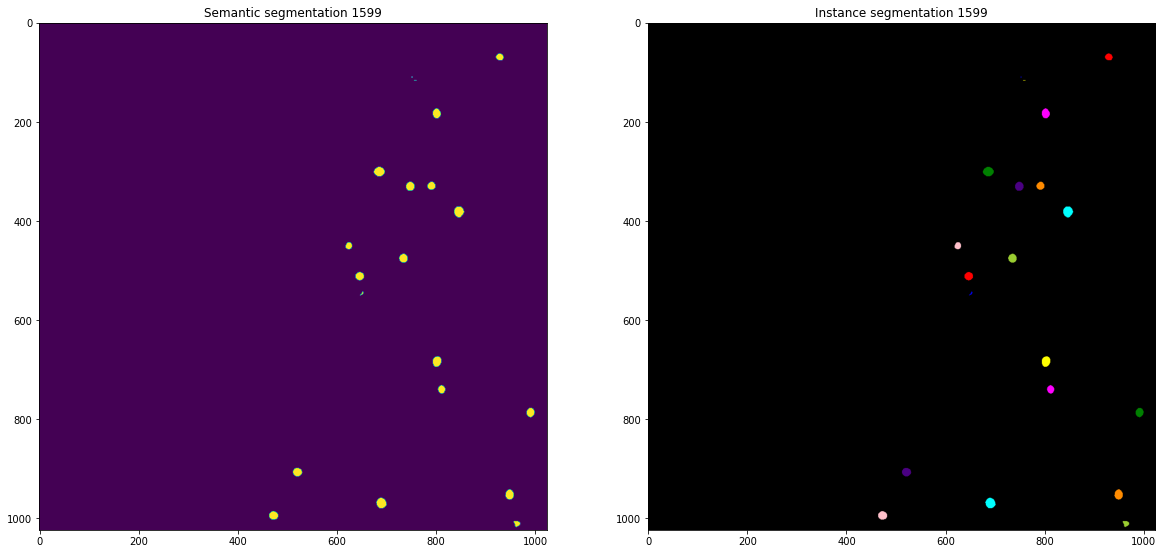

1444.nii


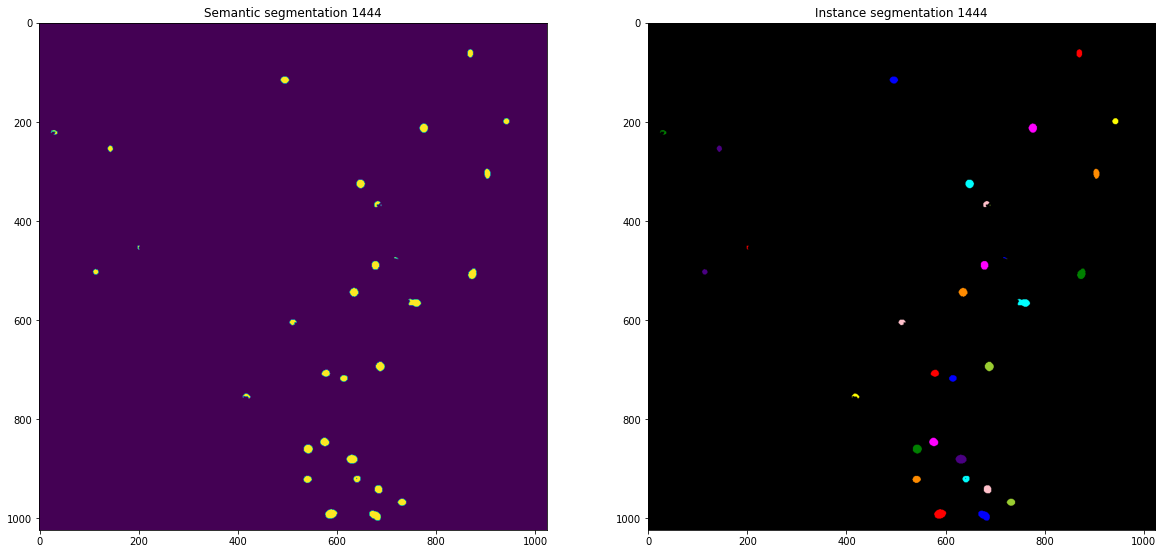

1283.nii


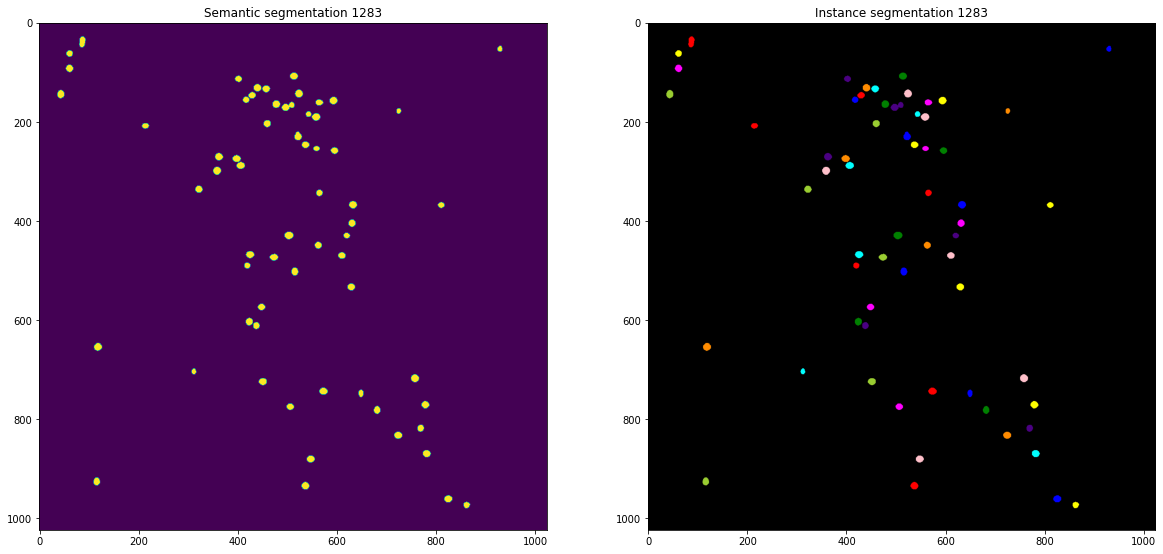

1237.nii


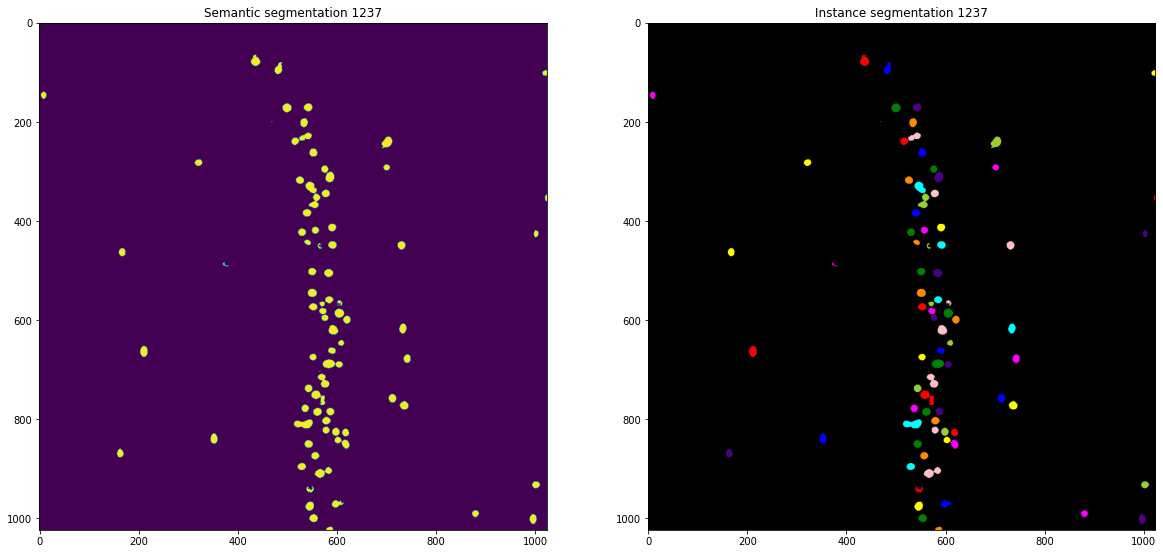

1377.nii


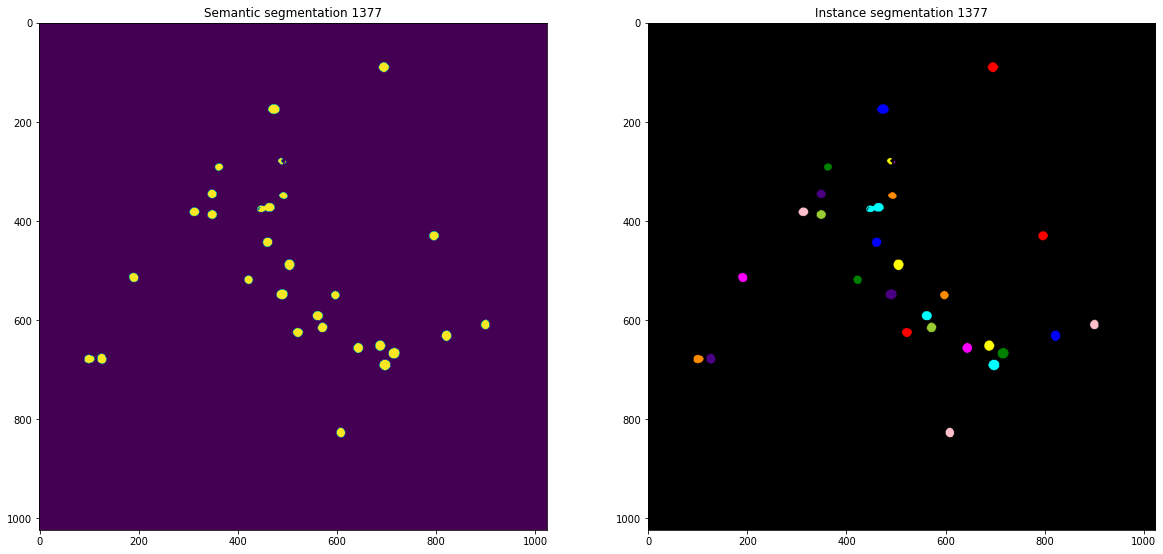

1418.nii


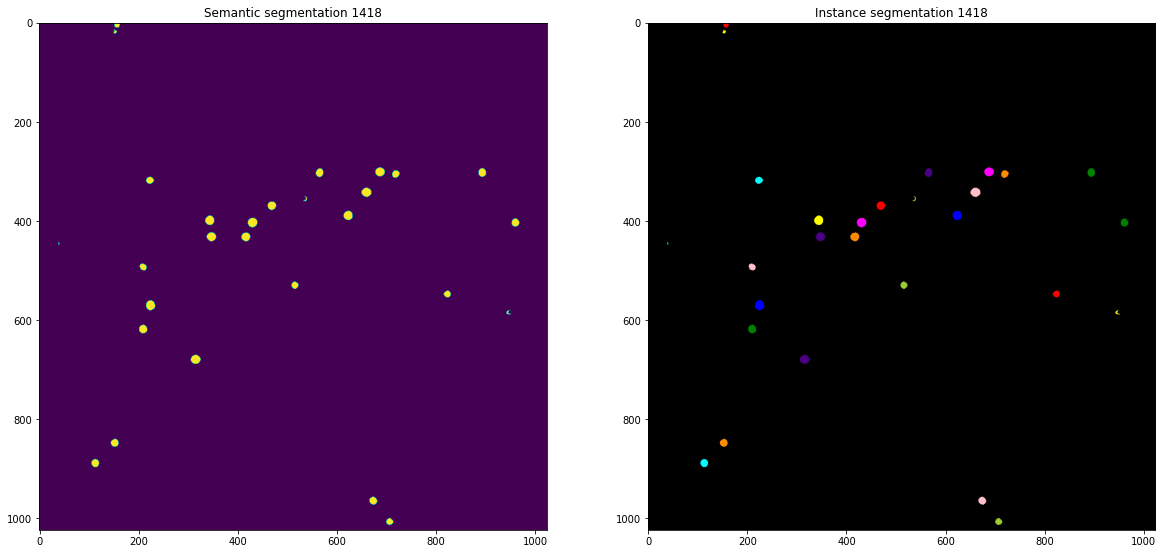

1582.nii


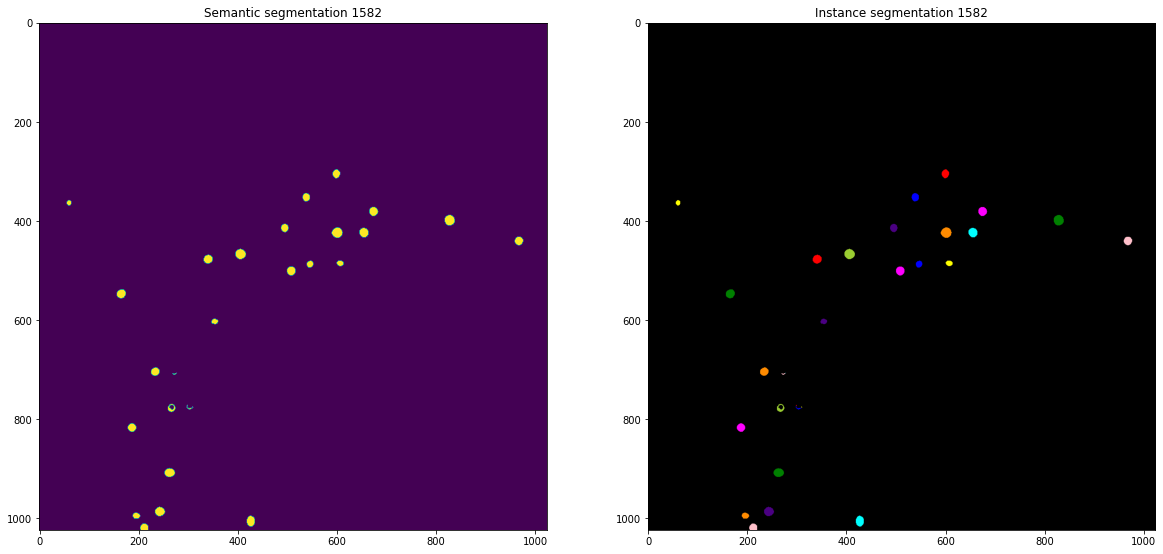

1385.nii


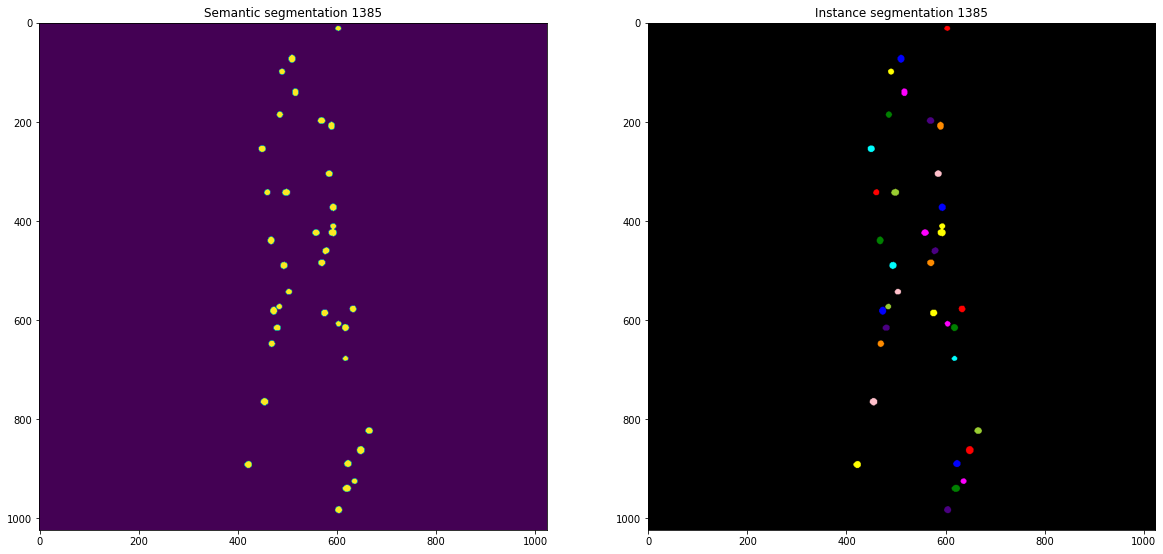

In [ ]:
prediction_path = Path(prediction_dir)
files = [x for x in prediction_path.iterdir() if x.suffix=='.gz']

for f in files:
    print(f.stem)
    idx = f.stem[:-4]
    pred = np.array(nib.load(f).dataobj)
    pred = np.fliplr(np.rot90(pred, 3))[...,0]

    # Save semantic segmentation prediction
    masks_path = prediction_path/'masks'
    masks_path.mkdir(exist_ok=True)
    imageio.imwrite(masks_path/f'{idx}.png', (pred*255).astype('uint8'))

    # Save instance segmentation prediction
    instance_masks_path = prediction_path/'instance_masks'
    instance_masks_path.mkdir(exist_ok=True)
    _, label_msk = cv2.connectedComponents(pred.astype('uint8'), connectivity=4)
    tifffile.imwrite(instance_masks_path/f'{idx}.tif', label_msk.astype('int16'), compress=6)

    # Plot
    fig, axs = plt.subplots(ncols=2, figsize=(20,10))
    axs[0].imshow(pred)
    axs[0].set_title(f'Semantic segmentation {idx}')
    axs[1].imshow(label2rgb(label_msk, bg_label=0))
    axs[1].set_title(f'Instance segmentation {idx}')
    plt.show()